<a href="https://colab.research.google.com/github/power-TY/ML_TeamProject/blob/main/Data_preprocess_outlier_OneHot_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#method : scaling, log transformation, cube Root normalization, Box-Cox transformation
from scipy.stats import skew 
from scipy.stats import boxcox

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('/content/drive/MyDrive/기계학습 팀플/heart_2020_cleaned.csv')
df.shape

(319795, 18)

In [8]:
df = df.drop_duplicates()
df.shape

(301717, 18)

In [9]:
# noise 처리
df = df[(df['BMI'] < 80) & (df['SleepTime'] != 24)]
df.shape

(301653, 18)

In [10]:
def yesno_tolabel(x):
    if (x == 'Yes') | (x == 'Yes (during pregnancy)') :
        return 1
    else:
        return 0

In [11]:
sex_map = {'Female' : 0, 'Male' : 1}
health_map = {'Excellent' : 4, 'Very good' : 3, 'Good' : 2, 'Fair' : 1, 'Poor' : 0}
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
age_map = {'18-24' : 20, '25-29' : 25, '30-34' : 30, '35-39' : 35, '40-44' : 40, '45-49' : 45, '50-54' : 50, '55-59' : 55, '60-64' : 60, '65-69' : 65, '70-74' : 70, '75-79' : 75, '80 or older' : 80}
columns = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
for column in columns:
    df[column] = df[column].apply(lambda x : yesno_tolabel(x))

df['Sex'] = df['Sex'].map(sex_map)
df['GenHealth'] = df['GenHealth'].map(health_map)
df['Diabetic'] = df['Diabetic'].map(diabetic_map)
df['AgeCategory'] = df['AgeCategory'].map(age_map)

In [12]:
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,0,55,White,2,1,3,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,80,White,0,1,3,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,65,White,2,1,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,75,White,0,0,2,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,40,White,0,1,3,8.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,1,60,Hispanic,2,0,1,6.0,1,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,1,35,Hispanic,0,1,3,5.0,1,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,0,45,Hispanic,0,1,2,6.0,0,0,0
319793,0,32.81,0,0,0,0.0,0.0,0,0,25,Hispanic,0,0,2,12.0,0,0,0


In [13]:
def quantile_operation(outlier_df, column):
    quantile_1 = outlier_df[column].quantile(0.25)
    quantile_3 = outlier_df[column].quantile(0.75)
    iqr = quantile_3 - quantile_1
    Lower_tail = quantile_1 - 1.5 * iqr
    Upper_tail = quantile_3 + 1.5 * iqr

    return Lower_tail, Upper_tail

In [14]:

df['PhysicalHealth'] = df['PhysicalHealth'] + 1
df['MentalHealth'] = df['MentalHealth'] + 1
outlier_columns = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
for column in outlier_columns:
    Lower_tail, Upper_tail = quantile_operation(df, column)
    df[column] = boxcox(df[column])[0]

In [15]:
#Race 인코딩 - 원핫인코딩
from sklearn.preprocessing import OneHotEncoder
import numpy as np

ohe = OneHotEncoder(sparse = False)
train_race = ohe.fit_transform(df[['Race']])

ohe_hot_df = pd.DataFrame(train_race, columns = ohe.categories_)

df = df.reset_index().drop('index', axis = 1)

df = pd.concat([df, ohe_hot_df], axis = 1).drop('Race', axis = 1)

df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,SleepTime,Asthma,KidneyDisease,SkinCancer,"(American Indian/Alaskan Native,)","(Asian,)","(Black,)","(Hispanic,)","(Other,)","(White,)"
0,0,1.403407,1,0,0,0.669364,1.089487,0,0,55,...,3.488639,1,0,1,0.0,0.0,0.0,0.0,0.0,1.0
1,0,1.442302,0,0,1,0.000000,0.000000,0,0,80,...,5.054525,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,1.487128,1,0,0,0.801003,1.089487,0,1,65,...,5.813435,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,1.472250,0,0,0,0.000000,0.000000,0,0,75,...,4.280563,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0
4,0,1.468816,0,0,0,0.807551,0.000000,1,0,40,...,5.813435,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301648,1,1.491857,1,0,0,0.755892,0.000000,1,1,60,...,4.280563,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0
301649,0,1.504497,1,0,0,0.000000,0.000000,0,1,35,...,3.488639,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0
301650,0,1.472452,0,0,0,0.000000,0.000000,0,0,45,...,4.280563,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
301651,0,1.517915,0,0,0,0.000000,0.000000,0,0,25,...,8.734516,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
# x y분리
x=df.drop('HeartDisease', axis=1)
x_columns=x.columns
y=df['HeartDisease']

In [17]:
# train test 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.2,random_state = 42)

In [18]:
# 데이터 불균형 처리 전 상태

print('origin target data :\n', df['HeartDisease'].value_counts())

origin target data :
 0    274401
1     27252
Name: HeartDisease, dtype: int64


In [ ]:
# 언더 샘플링 처리 <- 코드만 남겨둘게요
from imblearn.under_sampling import *

#CNN
#x_train_CNN, y_train_CNN =CondensedNearestNeighbour(random_state=42).fit_resample(x_train, y_train) 

#ENN
#x_train_ENN, y_train_ENN =EditedNearestNeighbours(kind_sel="all", n_neighbors=5).fit_resample(x_train, y_train) 

#Tomek's link
#x_train_Tomek, y_train_Tomek =TomekLinks().fit_resample(x_train, y_train) 

#OSS
#x_train_OSS, y_train_OSS =OneSidedSelection(random_state=42).fit_resample(x_train, y_train) 

#NCR
#x_train_NCR, y_train_NCR =NeighbourhoodCleaningRule().fit_resample(x_train, y_train) 


#NearMiss-1
#x_train_NearMiss, y_train_NearMiss=NearMiss().fit_resample(x_train, y_train) 

In [ ]:
# # 언더 샘플링 결과 보기

# print('befor undersampling :\n', y_train.value_counts())
# print('\nAfter CNN :\n', y_train_CNN.value_counts())
# print('\n\n')

# print('befor undersampling :\n', y_train.value_counts()) #효과 미미 0=164205, 1=21811
# print('\nAfter ENN :\n', y_train_ENN.value_counts())
# print('\n\n')

# print('befor undersampling :\n', y_train.value_counts())  
# print('\nAfter TomekLink :\n', y_train_Tomek.value_counts())
# print('\n\n')

# print('befor undersampling :\n', y_train.value_counts()) #효과 미미 0=212240, 1=21811
# print('\nAfter OSS :\n', y_train_OSS.value_counts())
# print('\n\n')

# print('befor undersampling :\n', y_train.value_counts()) # 0=179268, 1=21811
# print('\nAfter NCR :\n', y_train_NCR.value_counts())
# print('\n\n')

# print('befor undersampling :\n', y_train.value_counts()) # 1대1 언더샘플링 너무 많은 손실?? 0,1=21811
# print('\nAfter NearMiss :\n', y_train_NearMiss.value_counts())
# print('\n\n')

In [19]:
##오버샘플링 처리
from imblearn.over_sampling import *

#SMOTE
x_train_SMOTE, y_train_SMOTE =SMOTE(random_state=42).fit_resample(x_train, y_train)
#BorderlineSMOTE
x_train_BorderlineSM, y_train_BorderlineSM =BorderlineSMOTE(random_state=42).fit_resample(x_train, y_train)

#SVMSMOTE
x_train_SVMSMOTE, y_train_SVMSMOTE =SVMSMOTE(random_state=42).fit_resample(x_train, y_train) 

#ADASYN
x_train_ADASYN, y_train_ADASYN =ADASYN(random_state=42).fit_resample(x_train, y_train) 

In [20]:
#오버 샘플링 결과

print('befor oversampling :\n', y_train.value_counts())
print('\nAfter SMOTE :\n', y_train_SMOTE.value_counts())
print('\n\n')
print('befor oversampling :\n', y_train.value_counts())
print('\nAfter BoderlineSMOTE :\n', y_train_BorderlineSM.value_counts())
print('\n\n')
print('befor oversampling :\n', y_train.value_counts())
print('\nAfter SVMSMOTE :\n', y_train_SVMSMOTE.value_counts())
print('\n\n')
print('befor oversampling :\n', y_train.value_counts())
print('\nAfter ADASYN :\n', y_train_ADASYN.value_counts())
print('\n\n')

befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After SMOTE :
 1    219556
0    219556
Name: HeartDisease, dtype: int64



befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After BoderlineSMOTE :
 1    219556
0    219556
Name: HeartDisease, dtype: int64



befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After SVMSMOTE :
 1    219556
0    219556
Name: HeartDisease, dtype: int64



befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After ADASYN :
 1    220212
0    219556
Name: HeartDisease, dtype: int64





In [21]:
# 복합 샘플링 진행 
from imblearn.combine import *

## SMOTETomek <- 얘는 사용한다는 말이 없었어서 일단 주석처리 하겠습니다. 
#x_train_SMOTETomek, y_train_SMOTETomek =SMOTETomek(random_state=42).fit_resample(x_train, y_train)  

#SMOTETENN
x_train_SMOTEENN, y_train_SMOTEENN =SMOTEENN(random_state=42).fit_resample(x_train, y_train) 

In [22]:
 #복합 샘플링 결과
# print('befor combinesampling :\n', y_train.value_counts())
# print('\nAfter SMOTETomek :\n', y_train_SMOTETomek.value_counts())
# print('\n\n')
print('befor combinesampling :\n', y_train.value_counts())
print('\nAfter SMOTEENN :\n', y_train_SMOTEENN.value_counts())

befor combinesampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After SMOTEENN :
 1    173392
0    163876
Name: HeartDisease, dtype: int64


Accuracy 0.9103280237357246
Precision 0.5339892665474061
Recall 0.10882245716368939
F1 0.18079951544518472
AUC 0.8363305187751635
[[54324   521]
 [ 4889   597]]


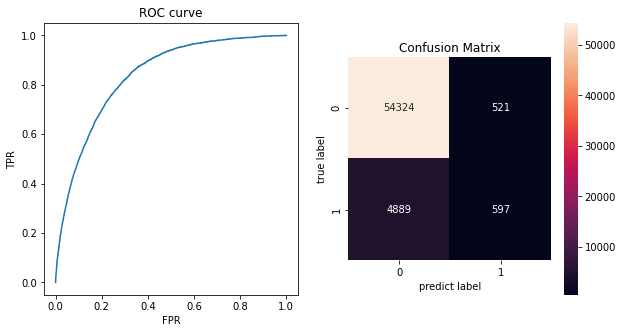

In [23]:
#로지스틱 이용 샘플링 안한경우
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7338681606470968
Precision 0.22078402366863906
Recall 0.7617572001458257
F1 0.3423445564020644
AUC 0.820478201468381
[[40096 14749]
 [ 1307  4179]]


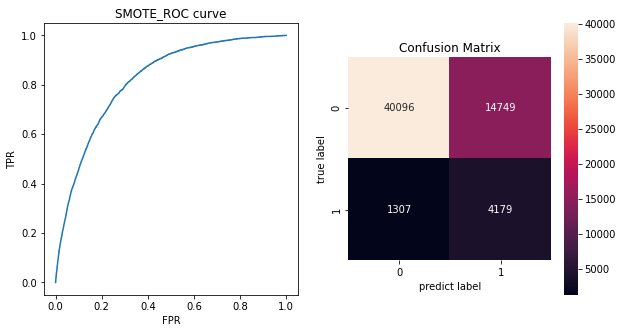

In [24]:
#SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression()
model.fit(x_train_SMOTE, y_train_SMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7589962042730934
Precision 0.2350152189182861
Recall 0.7318629238060518
F1 0.35578201151971645
AUC 0.8256646369626768
[[41776 13069]
 [ 1471  4015]]


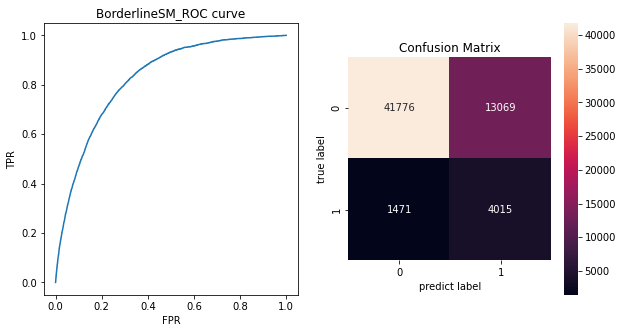

In [25]:
#BorderlineSMote
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression()
model.fit(x_train_BorderlineSM, y_train_BorderlineSM)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('BorderlineSM_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.806036697551839
Precision 0.2684053651266766
Recall 0.6565803864382064
F1 0.38104305511477843
AUC 0.8310260327658562
[[45027  9818]
 [ 1884  3602]]


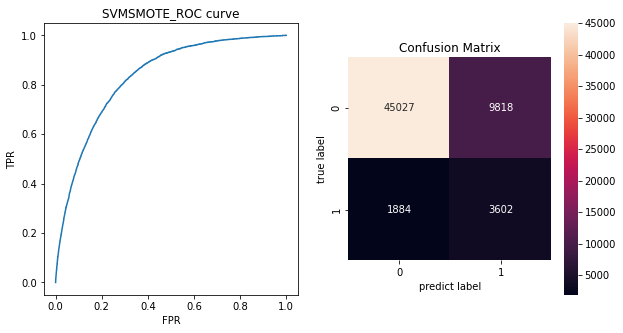

In [26]:
#SVMSMote
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression()
model.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SVMSMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7161326681142365
Precision 0.21136679230311445
Recall 0.7768866204885162
F1 0.33231968810916174
AUC 0.8154337994986501
[[38943 15902]
 [ 1224  4262]]


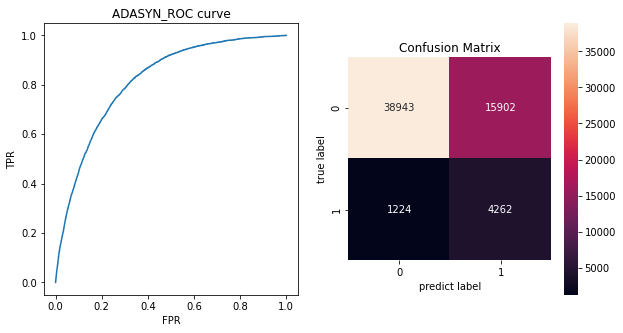

In [27]:
#ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression()
model.fit(x_train_ADASYN, y_train_ADASYN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ADASYN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7088064179277651
Precision 0.2118943151468905
Recall 0.8098796937659497
F1 0.33590383306872307
AUC 0.8292372479004647
[[38320 16525]
 [ 1043  4443]]


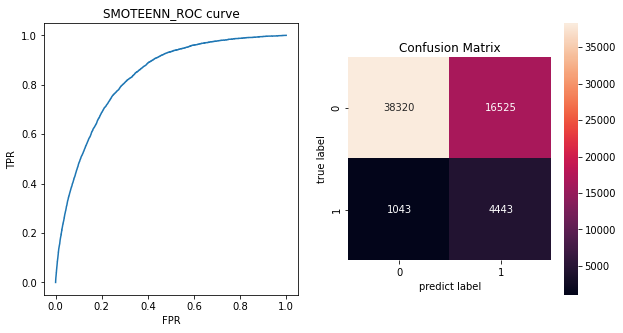

In [28]:
#SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression()
model.fit(x_train_SMOTEENN, y_train_SMOTEENN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTEENN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7461172531534369
Precision 0.23196466546703745
Recall 0.7754283631060882
F1 0.35710388247639036
AUC 0.8367655664472112
[[40760 14085]
 [ 1232  4254]]


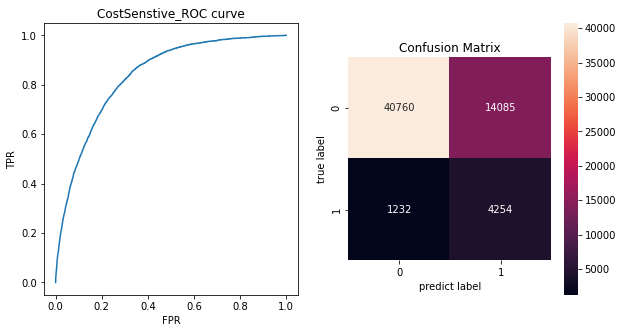

In [29]:
#Costsensitive
#원본 데이터를 가지고 class-weight 이용 로지스틱
model = LogisticRegression(class_weight='balanced')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('CostSenstive_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()
